## Import Dependencies

In [1]:
import glob
import shutil
import matplotlib
import torch.utils
import torch.utils.data
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
from configs.general import EXPERIMENT_BASE_DIR, EXPERIMENT_INFO_PATH, \
    EXPERIMENT_COLS, DEVICE, FILTERING_EXPERIMENT_INFO_PATH, FILTERING_EXPERIMENT_BASE_DIR, FILTERING_EXPERIMENT_COLS, BASE_DIR
from model import get as get_model
from configs import configs
from data.set import  GeneralDataset
from plottable import ColumnDefinition
from plottable import Table
from torchvision import transforms as t
from plottable.cmap import normed_cmap
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torch.nn.functional import softmax
from sklearn.preprocessing import MinMaxScaler
from utils.plot import draw_stacked_bars

scaler = MinMaxScaler()

/home/vision/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Calculate test accuracy for done experiments 

In [ ]:
from configs.cifar10 import Config as Cifar10Config
transform = t.Compose([
        t.ToTensor(),
        t.Normalize(mean=Cifar10Config.mean, std=Cifar10Config.std),
    ])


shutil.copy(EXPERIMENT_INFO_PATH, EXPERIMENT_INFO_PATH+".swp")
experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = experiments[(experiments['done'] == True) & (experiments['test_acc'].isna())]
z = input(f"num experiments: {len(target_experiments)} ok?(y/n)")
if z != 'y':
    raise Exception("Unable to continue")
while not target_experiments.empty:
    target_experiments = experiments[(experiments['done'] == True) & (experiments['test_acc'].isna())]
    print('TODO: ',len(target_experiments))
    for index, row in target_experiments.head(10).iterrows():
        test_acc = []
        for fold in range(row['folds']):
            experitment_dir = osp.join(EXPERIMENT_BASE_DIR, *[row[col] for col in EXPERIMENT_COLS], str(fold))
            glob_regex = osp.join(experitment_dir, '*last_model.pt')
            model_path = sorted(glob.glob(glob_regex))[0]
            model = get_model(name=row['model'], num_classes=len(configs[row['dataset']].classes), dropout=float(row['dropout'][4:]))

            model.load_state_dict(torch.load(model_path))
            model.to(DEVICE)

            test_dataset = GeneralDataset(dataset_name=row['dataset'], label_column='true_label', phase='test', transform=transform)
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
            model.eval()

            all_labels = []
            all_predictions = []
            with torch.no_grad():
                validation_epoch_loss = []
                iteration = 0
                for idx, data, labels in test_loader:
                    data, labels = data.to(DEVICE), labels.to(DEVICE)
                    prediction_values = model(data)  # (B, C)
                    prediction_probs = softmax(prediction_values, dim=1)  # (B, C)

                    all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())
                    all_predictions.extend(torch.max(prediction_probs, 1)[1].cpu().numpy())

            # Calculate overall accuracy
            overall_accuracy = (accuracy_score(all_labels, all_predictions) * 100).round(2)
            test_acc.append(overall_accuracy)
        print('test_acc: ', test_acc)
        print('---index: ', index)
        experiments.at[index, 'test_acc'] = f"{test_acc[0]} {test_acc[1]} {test_acc[2]}"
    experiments.to_csv(EXPERIMENT_INFO_PATH)


### Best test acc all

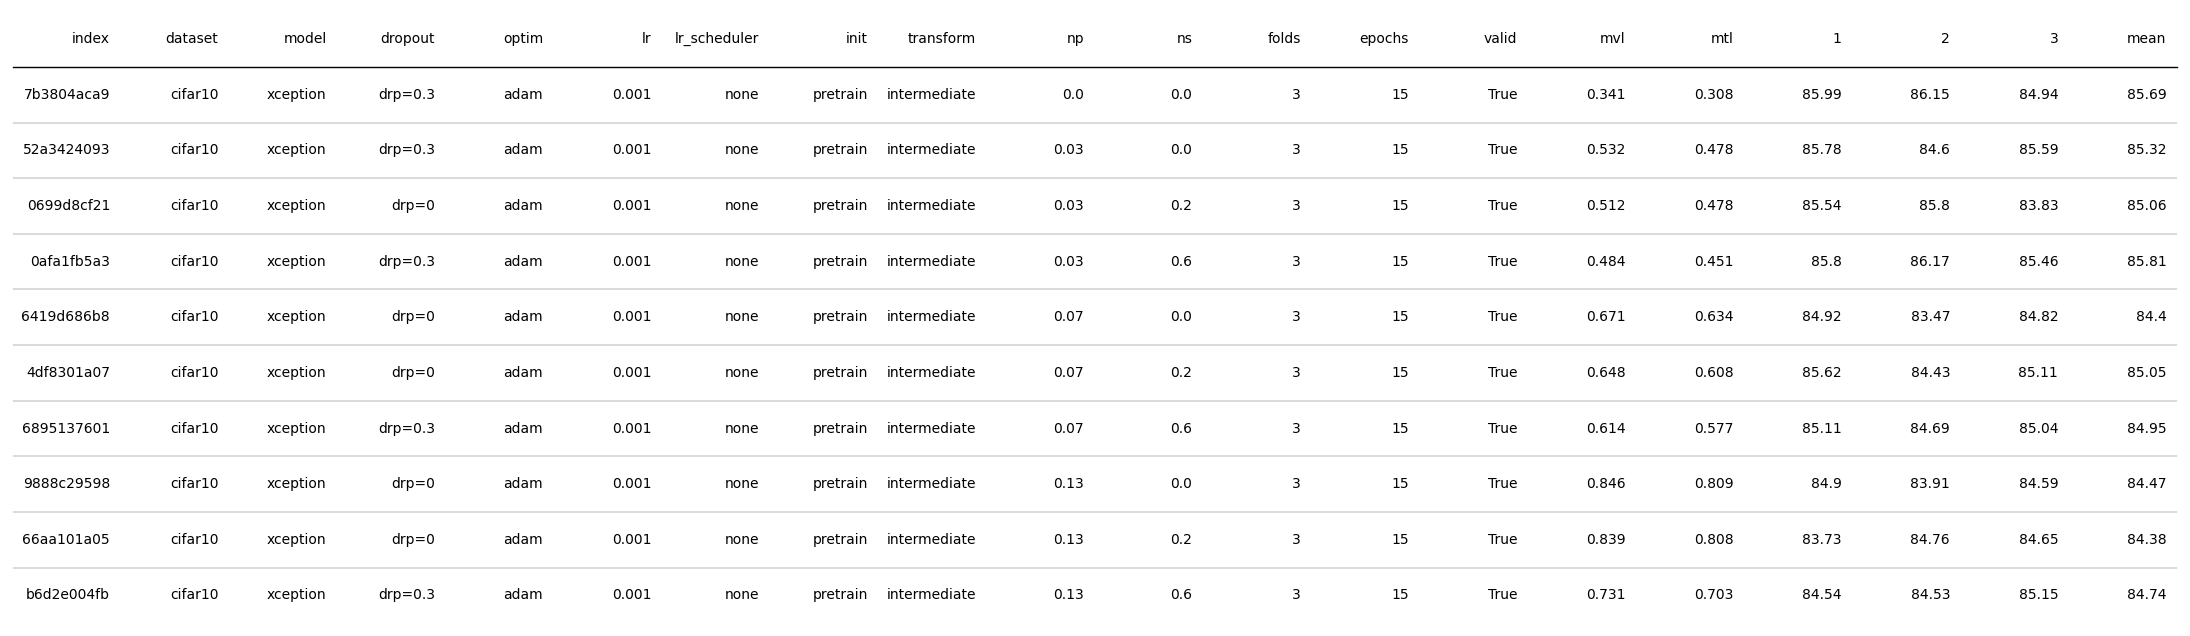

In [13]:

target_experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = target_experiments[(target_experiments['done'] == True) & (~target_experiments['test_acc'].isna())]
if 'validation_loss' in target_experiments.columns:
    target_experiments['mvl'] = target_experiments['validation_loss'].apply(lambda x: np.mean([float(z) for z in x.split()]).round(3)) 
    target_experiments['mtl'] = target_experiments['train_loss'].apply(lambda x: np.mean([float(z) for z in x.split()]).round(3)) 
    target_experiments.drop(columns=['validation_loss', 'train_loss'], inplace=True)
result = pd.DataFrame()
for index, row in target_experiments.iterrows():
    test_acc = [float(x) for x in row['test_acc'].split()]
    target_experiments.at[index, '1'] = test_acc[0]
    target_experiments.at[index, '2'] = test_acc[1]
    target_experiments.at[index, '3'] = test_acc[2]
    target_experiments.at[index, 'mean'] = np.mean(test_acc).round(2)

max_ids = target_experiments.groupby(['np', 'ns'])['mean'].idxmax()
table = target_experiments.loc[max_ids]
table['np'] = table['np'].str.replace('np=', '').astype(float)
table['ns'] = table['ns'].str.replace('ns=', '').astype(float)
table['lr'] = table['lr'].str.replace('lr=', '').astype(float)
table = table.drop(columns=['test_acc', 'done'])
# print(z.head())


# Init a figure
fig, ax = plt.subplots(figsize=(28, 8))
tab = Table(table)
plt.show()

#### training result on 15 epochs based on xception model and lr_scheduler='reduceLR' without dropout and augmentation

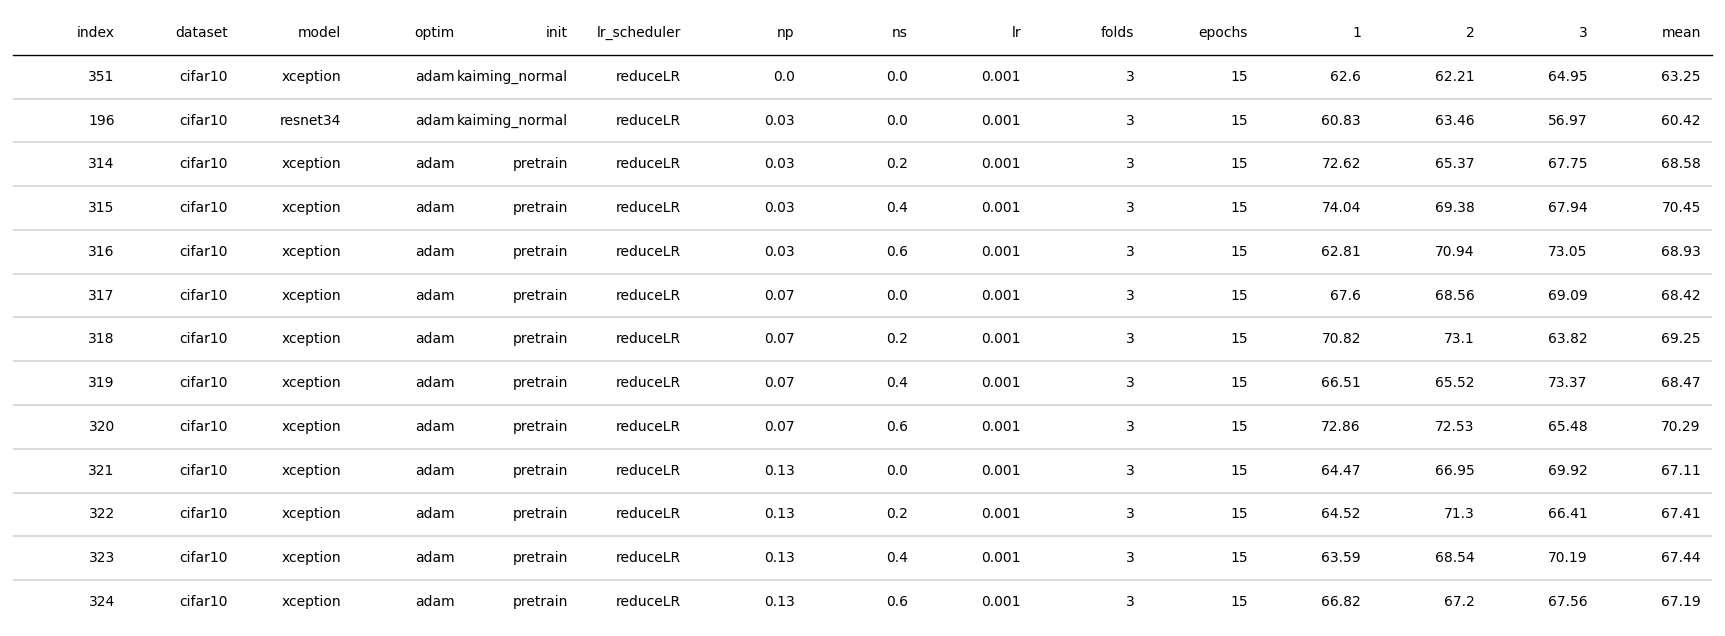

In [31]:
# Try training on 15 epochs based on xception model and lr_scheduler='reduceLR' without dropout and augmentation

## Calculate test accuracy for done filtering experiments 

In [ ]:
from configs.cifar10 import Config as Cifar10Config
transform = t.Compose([
        t.ToTensor(),
        t.Normalize(mean=Cifar10Config.mean, std=Cifar10Config.std),
    ])

shutil.copy(FILTERING_EXPERIMENT_INFO_PATH, FILTERING_EXPERIMENT_INFO_PATH+".swp")
experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
filtering_experiments = pd.read_csv(FILTERING_EXPERIMENT_INFO_PATH, index_col='index')

target_experiments = filtering_experiments[(filtering_experiments['done'] == True) & (filtering_experiments['test_acc'].isna())]

while not target_experiments.empty:
    target_experiments = filtering_experiments[(filtering_experiments['done'] == True) & (filtering_experiments['test_acc'].isna())]
    print('TODO: ',len(target_experiments))
    for index, row in target_experiments.head(10).iterrows():
        bex = row['basic_experiment_index']
        test_acc = []
        for fold in range(experiments.iloc[bex]['folds']):
            experitment_dir = osp.join(FILTERING_EXPERIMENT_BASE_DIR, *[str(row[col]) for col in FILTERING_EXPERIMENT_COLS], str(fold))
            glob_regex = osp.join(experitment_dir, '*best_model.pt')
            print('glob_regex: ', glob_regex)
            print('glob.glob(glob_regex): ', glob.glob(glob_regex))
            model_path = sorted(glob.glob(glob_regex))[0]
            model = get_model(name=experiments.iloc[bex]['model'], num_classes=len(configs[experiments.iloc[bex]['dataset']].classes))
            model.load_state_dict(torch.load(model_path))
            model.to(DEVICE)

            test_dataset = GeneralDataset(dataset_name=experiments.iloc[bex]['dataset'], label_column='true_label', phase='test', transform=transform)
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
            model.eval()

            all_labels = []
            all_predictions = []
            with torch.no_grad():
                validation_epoch_loss = []
                iteration = 0
                for idx, data, labels in test_loader:
                    data, labels = data.to(DEVICE), labels.to(DEVICE)
                    prediction_values = model(data)  # (B, C)
                    prediction_probs = softmax(prediction_values, dim=1)  # (B, C)

                    all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())
                    all_predictions.extend(torch.max(prediction_probs, 1)[1].cpu().numpy())

            # Calculate overall accuracy
            overall_accuracy = (accuracy_score(all_labels, all_predictions) * 100).round(2)
            test_acc.append(overall_accuracy)
        print('test_acc: ', test_acc)
        print('---index: ', index)
        filtering_experiments.at[index, 'test_acc'] = f"{test_acc[0]} {test_acc[1]} {test_acc[2]}"
    filtering_experiments.to_csv(FILTERING_EXPERIMENT_INFO_PATH)


### Best test acc all

In [ ]:

filtering_experiments = pd.read_csv(FILTERING_EXPERIMENT_INFO_PATH, index_col='index')
filtering_experiments = filtering_experiments[filtering_experiments['done'] == True]

target_experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = target_experiments.iloc[np.unique(filtering_experiments['basic_experiment_index'])]
target_experiments = target_experiments[['dataset', 'model', 'optim', 'init', 'lr_scheduler', 'np', 'ns']]
merged_df = pd.merge(left=target_experiments, right=filtering_experiments, left_index=True, right_on="basic_experiment_index")
result = pd.DataFrame()
for index, row in merged_df.iterrows():
    test_acc = [float(x) for x in row['test_acc'].split()]
    merged_df.at[index, '1'] = test_acc[0]
    merged_df.at[index, '2'] = test_acc[1]
    merged_df.at[index, '3'] = test_acc[2]
    merged_df.at[index, 'mean'] = np.mean(test_acc).round(2)

max_ids = merged_df.groupby(['np', 'ns'])['mean'].idxmax()
table = merged_df.loc[max_ids]
table['np'] = table['np'].str.replace('np=', '').astype(float)
table['ns'] = table['ns'].str.replace('ns=', '').astype(float)
table = table.drop(columns=['test_acc', 'done'])

# Init a figure
fig, ax = plt.subplots(figsize=(22, 8))
tab = Table(table)
plt.show()

#### training result on 15 epochs based on xception model and lr_scheduler='reduceLR' without dropout and augmentation

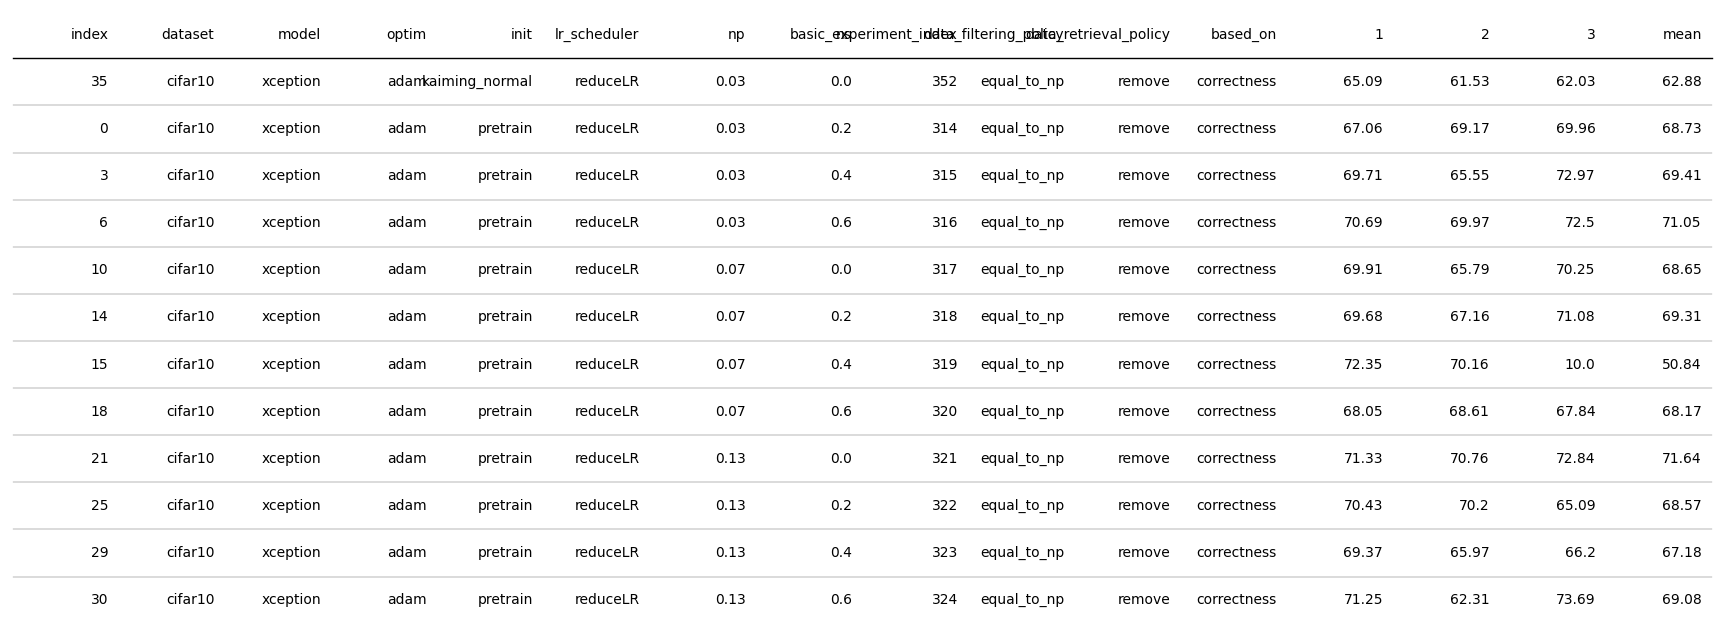

In [50]:
# training result on 15 epochs based on xception model and lr_scheduler='reduceLR' without dropout and augmentation

## Rate experiment based on test acc result

58













/tmp/ipykernel_169328/901303288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_experiments['mean_acc'] = target_experiments['test_acc'].apply(lambda x: np.mean([float(z) for z in x.split()]))


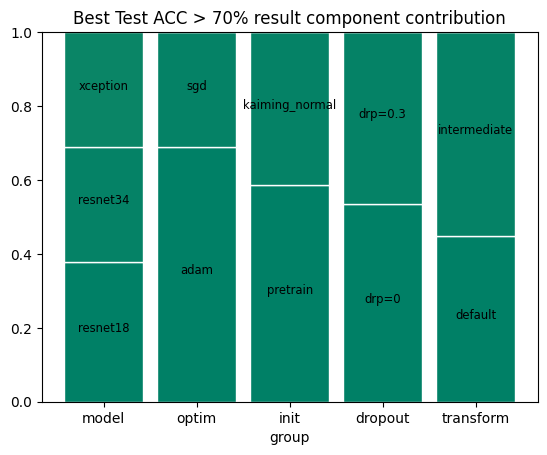

In [6]:
experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = experiments[(experiments['np'] == 'np=0.0') & (~ experiments['test_acc'].isna())]
target_experiments['mean_acc'] = target_experiments['test_acc'].apply(lambda x: np.mean([float(z) for z in x.split()]))
target_experiments = target_experiments[target_experiments['mean_acc'] > 70]
experiments.loc[target_experiments.index, 'valid'] = True
print((experiments['valid'] == True).sum())
draw_stacked_bars(target_experiments[['model', 'optim', 'init', 'dropout', 'transform']], title="Best Test ACC > 70% result component contribution")

22












/tmp/ipykernel_169328/344982055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_experiments['mean_acc'] = target_experiments['test_acc'].apply(lambda x: np.mean([float(z) for z in x.split()]))


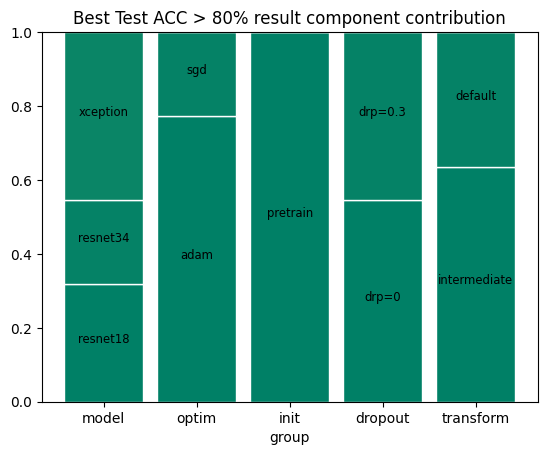

In [7]:
experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = experiments[(experiments['np'] == 'np=0.0') & (~ experiments['test_acc'].isna())]
target_experiments['mean_acc'] = target_experiments['test_acc'].apply(lambda x: np.mean([float(z) for z in x.split()]))
target_experiments = target_experiments[target_experiments['mean_acc'] > 80]
experiments.loc[target_experiments.index, 'valid'] = True
print((experiments['valid'] == True).sum())
draw_stacked_bars(target_experiments[['model', 'optim', 'init', 'dropout', 'transform']], title="Best Test ACC > 80% result component contribution")

8











/tmp/ipykernel_169328/744435299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_experiments['mean_acc'] = target_experiments['test_acc'].apply(lambda x: np.mean([float(z) for z in x.split()]))


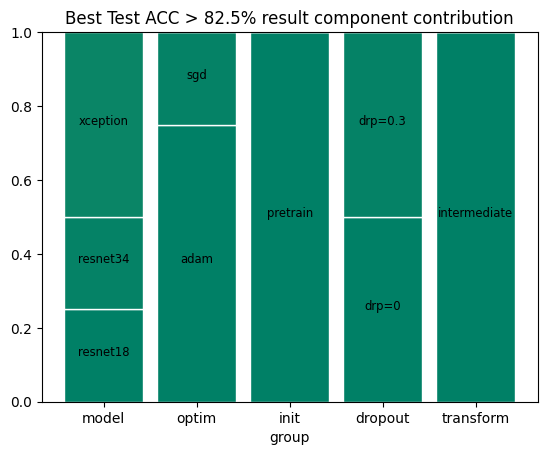

In [8]:
experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = experiments[(experiments['np'] == 'np=0.0') & (~ experiments['test_acc'].isna())]
target_experiments['mean_acc'] = target_experiments['test_acc'].apply(lambda x: np.mean([float(z) for z in x.split()]))
target_experiments = target_experiments[target_experiments['mean_acc'] > 82.5]
experiments.loc[target_experiments.index, 'valid'] = True
print((experiments['valid'] == True).sum())
draw_stacked_bars(target_experiments[['model', 'optim', 'init', 'dropout', 'transform']], title="Best Test ACC > 82.5% result component contribution")

In [29]:
valid_experiments = experiments[experiments['valid'] == True].copy()
for i, row in vx.iterrows():
    x = experiments[(experiments['dataset'] == row['dataset']) & (experiments['model'] == row['model']) & (experiments['optim'] == row['optim']) & (experiments['init'] == row['init']) & (experiments['dropout'] == row['dropout']) & (experiments['transform'] == row['transform']) & (experiments['lr'] == row['lr']) & (experiments['ns'] != "ns=0.4")]
    experiments.loc[x.index, 'valid'] = True
len(experiments[(experiments['valid'] == True) & experiments['done'] == True])

In [36]:
# experiments.to_csv(EXPERIMENT_INFO_PATH)

72

## Relation between test accuracy and auc

In [33]:
experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index')
target_experiments = experiments[(experiments['np'] == 'np=0.0') & (~ experiments['test_acc'].isna())]
target_experiments

,dataset,model,optim,init,lr_scheduler,np,ns,lr,folds,epochs,done,test_acc
index,,,,,,,,,,,,
312,cifar10,xception,adam,pretrain,reduceLR,np=0.0,ns=0.0,lr=0.001,3,15,True,71.41 10.0 73.24
351,cifar10,xception,adam,kaiming_normal,reduceLR,np=0.0,ns=0.0,lr=0.001,3,15,True,62.6 62.21 64.95
390,cifar10,xception,sgd,pretrain,reduceLR,np=0.0,ns=0.0,lr=0.1,3,15,True,10.0 10.0 10.0
429,cifar10,xception,sgd,kaiming_normal,reduceLR,np=0.0,ns=0.0,lr=0.1,3,15,True,54.46 47.7 56.3


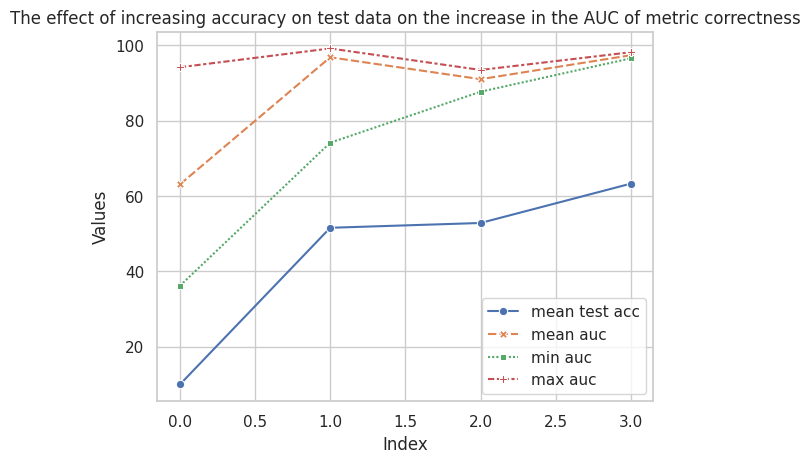

In [162]:
target_auc = pd.read_csv(osp.join(BASE_DIR, 'correctness_auc.csv'), index_col='index')

table = pd.DataFrame()
available_nps =  experiments['np'].unique()
for idx, row in target_experiments.iterrows():
    dataset, model, optim, init, lr_scheduler = row['dataset'], row['model'], row['optim'], row['init'], row['lr_scheduler']
    filtered_auc_experiment = target_auc[(target_auc['dataset'] == dataset) & (target_auc['model'] == model) & (target_auc['optim'] == optim) & (target_auc['init'] == init) & (target_auc['lr_scheduler'] == lr_scheduler) & ~(target_auc['np'] == 'np=0.0')]
    mean_auc_value, min_auc_value, max_auc_value = filtered_auc_experiment['correctness-train-auc'].mean(), filtered_auc_experiment['correctness-train-auc'].min(), filtered_auc_experiment['correctness-train-auc'].max()
    mean_test_acc = np.mean([float(x) for x in row['test_acc'].split()])
    table = table._append({
        # 'num': int(idx),
        'mean test acc': mean_test_acc,
        'mean auc': mean_auc_value * 100,
        'min auc': min_auc_value * 100,
        'max auc': max_auc_value * 100,
    }, ignore_index=True)
table = table.sort_values(by='mean test acc').reset_index()
table = table.drop(columns=['index'])

sns.set(style="whitegrid")  # Set the style
ax = sns.lineplot(data=table, markers=True)  # Plot the line plot
# Set labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('The effect of increasing accuracy on test data on the increase in the AUC of metric correctness')

# Show the plot
plt.show()


In [163]:
def get_auc_column(metric_name):
    if metric_name == 'correctness':
        return 'correctness-train-auc'
    elif metric_name == 'entropy':
        return 'entropy-std-train-auc'
    elif metric_name == 'id2m':
        return 'id2m-train-auc'
    elif metric_name == 'loss':
        return 'loss-std-validation-auc'
    elif metric_name == 'top_proba':
        return 'top_proba-mean-train-auc'

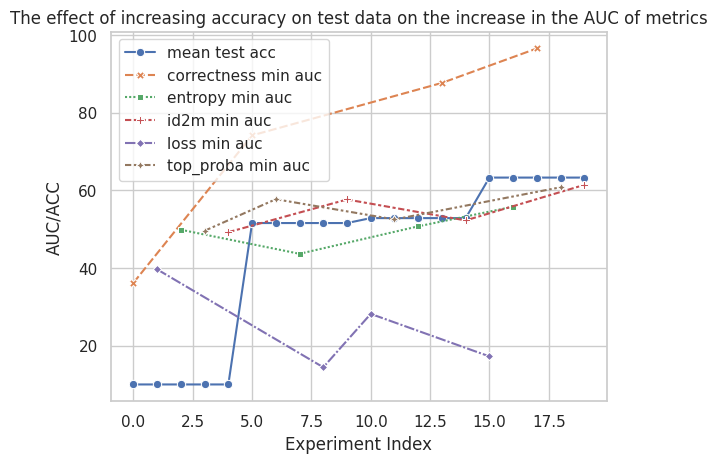

In [164]:
table = pd.DataFrame()
for metric_name in ['correctness', 'entropy', 'id2m', 'loss', 'top_proba']: 
    target_auc = pd.read_csv(osp.join(BASE_DIR, f'{metric_name}_auc.csv'), index_col='index')
    available_nps =  experiments['np'].unique()
    for idx, row in target_experiments.iterrows():
        dataset, model, optim, init, lr_scheduler = row['dataset'], row['model'], row['optim'], row['init'], row['lr_scheduler']
        filtered_auc_experiment = target_auc[(target_auc['dataset'] == dataset) & (target_auc['model'] == model) & (target_auc['optim'] == optim) & (target_auc['init'] == init) & (target_auc['lr_scheduler'] == lr_scheduler) & ~(target_auc['np'] == 'np=0.0')]
        min_auc_value = filtered_auc_experiment[get_auc_column(metric_name)].min()
        mean_test_acc = np.array([float(x) for x in row['test_acc'].split()]).mean()
        table = table._append({
            'mean test acc': mean_test_acc,
            f'{metric_name} min auc': min_auc_value * 100,
        }, ignore_index=True)
table = table.sort_values(by='mean test acc').reset_index()
table = table.drop(columns=['index'])

sns.set(style="whitegrid")  # Set the style
ax = sns.lineplot(data=table, markers=True)  # Plot the line plot
# Set labels and title
plt.xlabel('Experiment Index')
plt.ylabel('AUC/ACC')
plt.title('The effect of increasing accuracy on test data on the increase in the AUC of metrics')

# Show the plot
plt.show()
